In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dense, Activation
from flask import Flask, render_template, request
from werkzeug.utils import secure_filename
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#將使用者選到到的col放到最前面並儲存
def selected_ouput_col_and_save(pf,index,filename):
    pf.insert(0,index,pf.pop(index))
    pf.to_csv("temp\\"+filename,sep=',')

In [3]:
#分割訓練及測試資料
def split_train_test_data(pf,ratio):
    cols = pf.columns.tolist()
    y = pf[cols[1]]
    x = pf[cols[2:]]
    train_x , test_x  , train_y , test_y = train_test_split(x,y,test_size = ratio)
    return train_x , test_x  , train_y , test_y

In [4]:
# DNN 模型建構
def dnn_model_build(dnn_parameter,train_x,train_y):
    dnn_model = Sequential()
    dnn_model.add(Dense(int(dnn_parameter.layers[0][0]),input_dim = len(train_x.columns.tolist()),activation=dnn_parameter.layers[0][1]))
    for index in range(1,len(dnn_parameter.layers)):
        dnn_model.add(Dense(int(dnn_parameter.layers[index][0]),activation=dnn_parameter.layers[index][1]))
    dnn_model.add(Dense(output_dim = 1,activation='sigmoid'))
    dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = dnn_model.fit(train_x, train_y,epochs = int(dnn_parameter.epoch),verbose = 1 , validation_data=(train_x, train_y)) 
    return history

In [5]:
# 繪製訓練過程圖 並放置static
def train_history(history):
    plt.subplot(211)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel("accurary")
    plt.title("accurary history")
    plt.legend(['train_acc','test_acc'],loc='upper left')

    plt.subplot(212)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel("loss")
    plt.title("accurary history")
    plt.legend(['train_loss', 'test_loss'],loc='upper left')
    plt.xlabel("epoch")

    plt.tight_layout()
    plt.savefig('static\\train_history.jpg')
    plt.show()
    return True

In [6]:
#用以紀錄dnn的參數及超參數
class dnn_para():
    def __init__(self):
        self.filename = ""
        self.split = 0
        self.epoch = 1
        self.hidden_num = 1
        self.layers = []
    def set_filename(self,filename):
        self.filename = filename
    def set_split(self,split_ratio):
        self.split = split_ratio
    def set_epoch (self,epoch):
        self.epoch = epoch
    def set_hidden_num(self,hidden_num):
        self.hidden_num = hidden_num
    def set_layers(self,model):   
        layers = model.split('\t')
        for layer in layers:
            layer_para = layer.split(',')
            self.layers.append(layer_para)
dnn_parameter = dnn_para()  

In [ ]:
app = Flask(__name__)
upload_path = "temp"
app.config['UPLOAD_FOLDER'] = upload_path
      
dnn_model = Sequential()

#首頁
@app.route('/',methods = ['GET','POST'])
def main():   
    return render_template('home.html')

#選擇要用哪個服務(目前僅有DNN)
@app.route('/sever',methods = ['POST'])
def sever():
    if request.method == 'POST':
        sever_name = request.values.get('sever')
        if sever_name == 'DNN':
            return render_template('DNN_file.html') 
        return render_template('home.html')
    
# 上傳csv並選擇要當target的label
@app.route('/DNN_file',methods = ['POST'])
def dnn_file():
    if request.method == 'POST':
        file = request.files['upload']
        filename = secure_filename(file.filename)
        dnn_parameter.set_filename(filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'],filename))
        pf = pd.read_csv(upload_path+'\\'+filename)
        selected_col = request.values.get('selected_name').split(' ')[1]
        selected_ouput_col_and_save(pf,selected_col,filename)
        return render_template('DNN.html')
@app.route('/DNN',methods=['POST'])

#選擇DNN參數及超參數
def DNN():
    if request.method == 'POST':
        dnn_parameter.set_split(request.values.get('split_ratio'))
        dnn_parameter.set_epoch(request.values.get('epoch'))
        dnn_parameter.set_hidden_num(request.values.get('hidden_num'))
        dnn_parameter.set_layers(request.values.get('model'))
        pf = pd.read_csv(upload_path+'\\'+dnn_parameter.filename) 
        train_x , test_x  , train_y , test_y = split_train_test_data(pf,float(dnn_parameter.split))
        history = dnn_model_build(dnn_parameter,train_x,train_y)
        train_history(history)
        return render_template('dnn_model_fit.html')                          

 * Running on http://127.0.0.1:3000/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Oct/2020 13:32:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2020 13:32:24] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [24/Oct/2020 13:32:27] "POST /sever HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2020 13:32:45] "POST /DNN_file HTTP/1.1" 200 -
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  


Train on 623 samples, validate on 623 samples
Epoch 1/10
623/623 [==============================] - 0s 638us/step - loss: 2.6448 - accuracy: 0.0016 - val_loss: 2.5003 - val_accuracy: 0.0048
Epoch 2/10
623/623 [==============================] - 0s 117us/step - loss: 2.3587 - accuracy: 0.0048 - val_loss: 2.1782 - val_accuracy: 0.0048
Epoch 3/10
623/623 [==============================] - 0s 113us/step - loss: 1.9777 - accuracy: 0.0064 - val_loss: 1.7247 - val_accuracy: 0.0096
Epoch 4/10
623/623 [==============================] - 0s 111us/step - loss: 1.5802 - accuracy: 0.0096 - val_loss: 1.4215 - val_accuracy: 0.0096
Epoch 5/10
623/623 [==============================] - 0s 108us/step - loss: 1.2061 - accuracy: 0.0096 - val_loss: 0.9867 - val_accuracy: 0.0096
Epoch 6/10
623/623 [==============================] - 0s 119us/step - loss: 0.9100 - accuracy: 0.0096 - val_loss: 0.8348 - val_accuracy: 0.0112
Epoch 7/10
623/623 [==============================] - 0s 119us/step - loss: 0.7812 - accur

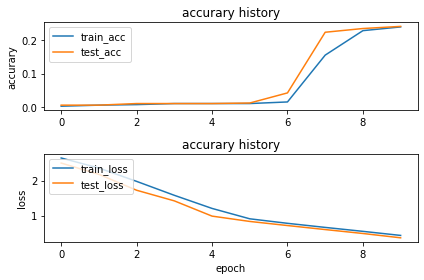

127.0.0.1 - - [24/Oct/2020 13:32:57] "POST /DNN HTTP/1.1" 200 -
127.0.0.1 - - [24/Oct/2020 13:32:57] "GET /static/train_history.jpg HTTP/1.1" 200 -


In [ ]:
if __name__ == '__main__':
    app.run(port=3000)